## Disease Classification and Drug recommendation
---


This system predicts diseases from symptoms and recommends medication, precautions, and diet tailored to each disease, enhancing health management.

### Importing all the necessary libraries



In [1]:
import pandas as pd
import itertools
import string
import numpy as np
import seaborn as sns
import joblib
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report



In [2]:
# Reading data
train_df = pd.read_csv("Training.csv")

In [3]:
train_df

,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,...,blackheads,scurring,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,prognosis
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
1,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
2,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
3,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
4,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4915,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,(vertigo) Paroymsal Positional Vertigo
4916,0,1,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,Acne
4917,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Urinary tract infection
4918,0,1,0,0,0,0,1,0,0,0,...,0,0,1,1,1,1,0,0,0,Psoriasis


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4920 entries, 0 to 4919
Columns: 133 entries, itching to prognosis
dtypes: int64(132), object(1)
memory usage: 5.0+ MB


# Checking whether the dataset is balanced or not

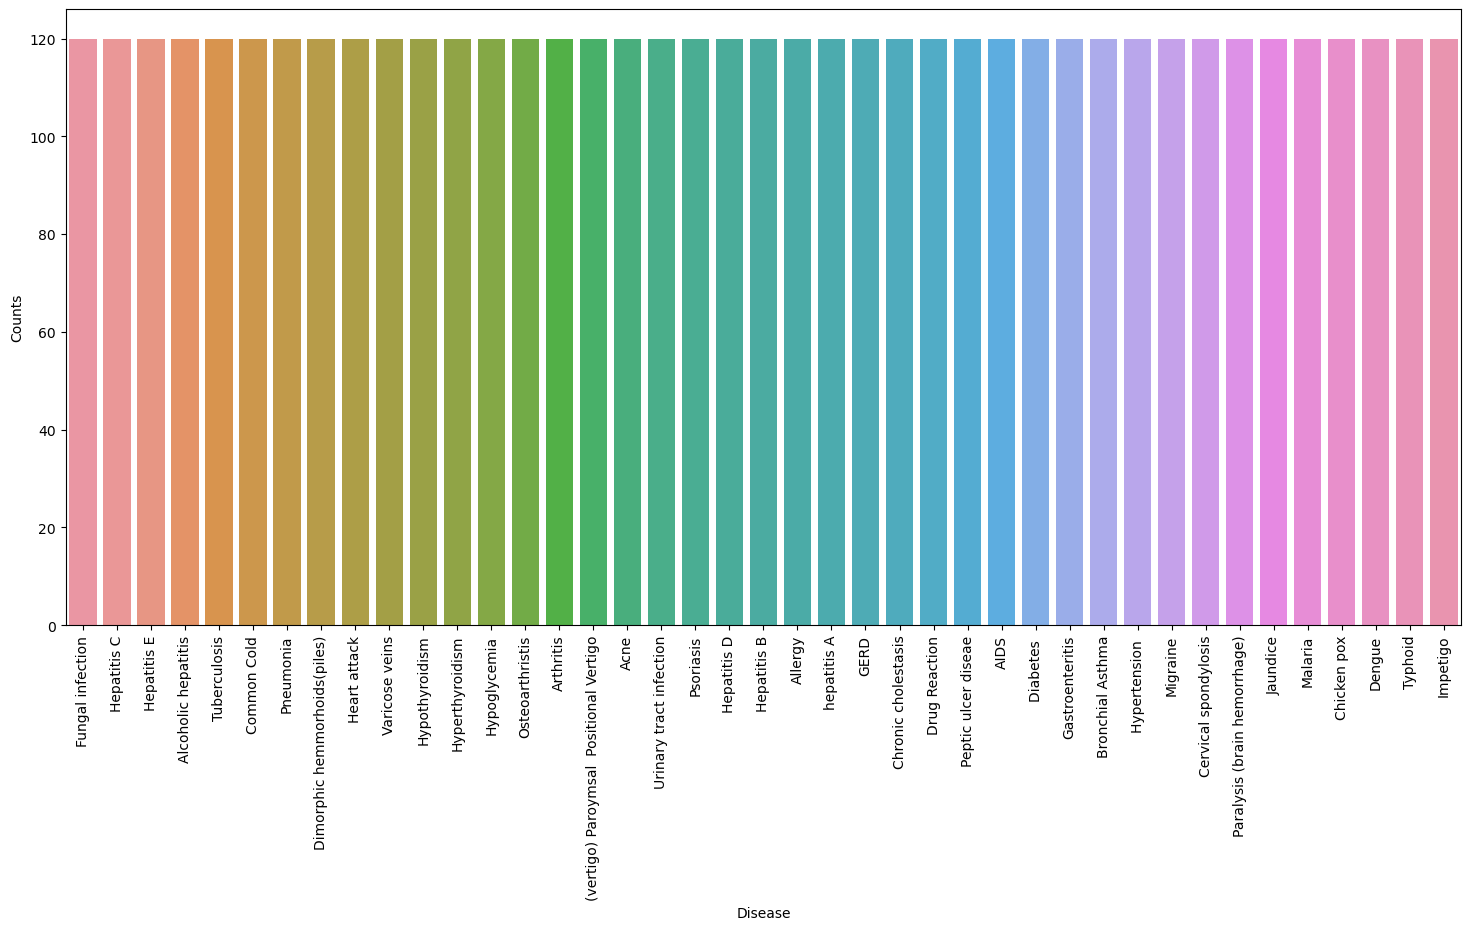

In [5]:
disease_counts = train_df["prognosis"].value_counts()
temp_df = pd.DataFrame({
    "Disease": disease_counts.index,
    "Counts": disease_counts.values
})

plt.figure(figsize = (18,8))
sns.barplot(x = "Disease", y = "Counts", data = temp_df)
plt.xticks(rotation=90)
plt.show()


The plot indicates a balanced dataset with 120 samples for each disease, suggesting no need for further balancing.

In [6]:
train_df['prognosis'].unique()

array(['Fungal infection', 'Allergy', 'GERD', 'Chronic cholestasis',
       'Drug Reaction', 'Peptic ulcer diseae', 'AIDS', 'Diabetes ',
       'Gastroenteritis', 'Bronchial Asthma', 'Hypertension ', 'Migraine',
       'Cervical spondylosis', 'Paralysis (brain hemorrhage)', 'Jaundice',
       'Malaria', 'Chicken pox', 'Dengue', 'Typhoid', 'hepatitis A',
       'Hepatitis B', 'Hepatitis C', 'Hepatitis D', 'Hepatitis E',
       'Alcoholic hepatitis', 'Tuberculosis', 'Common Cold', 'Pneumonia',
       'Dimorphic hemmorhoids(piles)', 'Heart attack', 'Varicose veins',
       'Hypothyroidism', 'Hyperthyroidism', 'Hypoglycemia',
       'Osteoarthristis', 'Arthritis',
       '(vertigo) Paroymsal  Positional Vertigo', 'Acne',
       'Urinary tract infection', 'Psoriasis', 'Impetigo'], dtype=object)

In [7]:
len(train_df['prognosis'].unique())

41

### classes and their corresponding labels



Label Encoder converts the labels into numerical form by assigning a unique index to the labels.

In [8]:

from sklearn.preprocessing import LabelEncoder

In [9]:

label_encoder = LabelEncoder()

# Fit the encoder
train_df["prognosis"] = label_encoder.fit_transform(train_df["prognosis"])
# Save label encoder
joblib.dump(label_encoder, "label_encoder.pkl")


['label_encoder.pkl']

In [10]:
for label, original_class in enumerate(label_encoder.classes_):
    print(f"{label}: {original_class}")

0: (vertigo) Paroymsal  Positional Vertigo
1: AIDS
2: Acne
3: Alcoholic hepatitis
4: Allergy
5: Arthritis
6: Bronchial Asthma
7: Cervical spondylosis
8: Chicken pox
9: Chronic cholestasis
10: Common Cold
11: Dengue
12: Diabetes 
13: Dimorphic hemmorhoids(piles)
14: Drug Reaction
15: Fungal infection
16: GERD
17: Gastroenteritis
18: Heart attack
19: Hepatitis B
20: Hepatitis C
21: Hepatitis D
22: Hepatitis E
23: Hypertension 
24: Hyperthyroidism
25: Hypoglycemia
26: Hypothyroidism
27: Impetigo
28: Jaundice
29: Malaria
30: Migraine
31: Osteoarthristis
32: Paralysis (brain hemorrhage)
33: Peptic ulcer diseae
34: Pneumonia
35: Psoriasis
36: Tuberculosis
37: Typhoid
38: Urinary tract infection
39: Varicose veins
40: hepatitis A


## Training and Testing split of the Training dataset

separating features and target

In [11]:

X = train_df.iloc[:,:-1]
y = train_df.iloc[:, -1]
X_train, X_test, y_train, y_test =train_test_split(
  X, y, test_size = 0.2, random_state = 24)

print(f"Train: {X_train.shape}, {y_train.shape}")
print(f"Test: {X_test.shape}, {y_test.shape}")


Train: (3936, 132), (3936,)
Test: (984, 132), (984,)


**Frequency of each symptom**

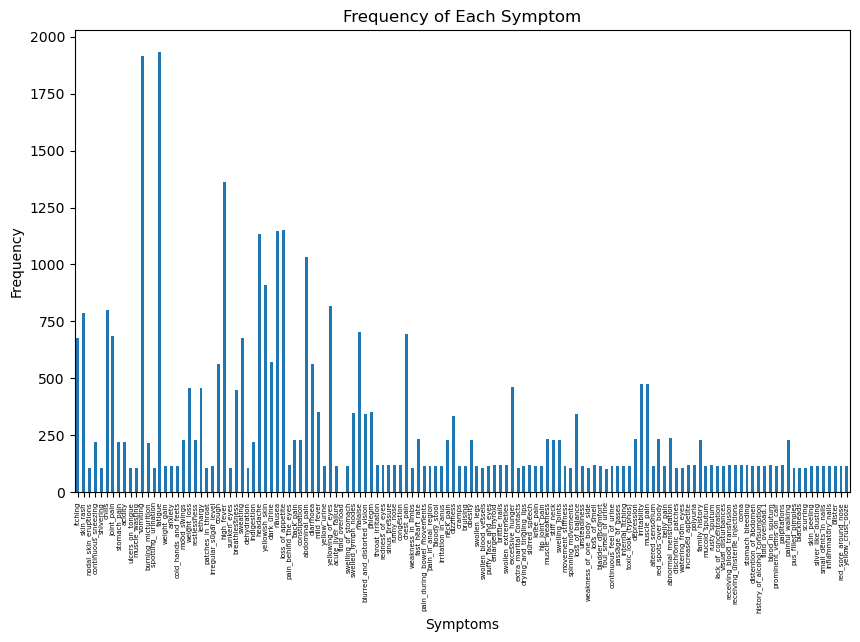

In [12]:
symptom_counts = X.sum()
plt.figure(figsize=(10,6))
symptom_counts.plot(kind='bar')
plt.title('Frequency of Each Symptom')
plt.xlabel('Symptoms')
plt.ylabel('Frequency')

# Rotate and resize the x-axis labels
plt.xticks(rotation=90, fontsize=5)

plt.show()


 The height of each bar represents the frequency of the corresponding symptom in your dataset. The frequency is calculated as the total count of each symptom, which works because the symptoms are encoded as 1 (for present) and 0 (for absent).

Each bar represents the frequency of a symptom. A taller bar indicates that the symptom is more common in your dataset, while a shorter bar indicates that the symptom is less common.


**Correlation between prognosis and symptoms**

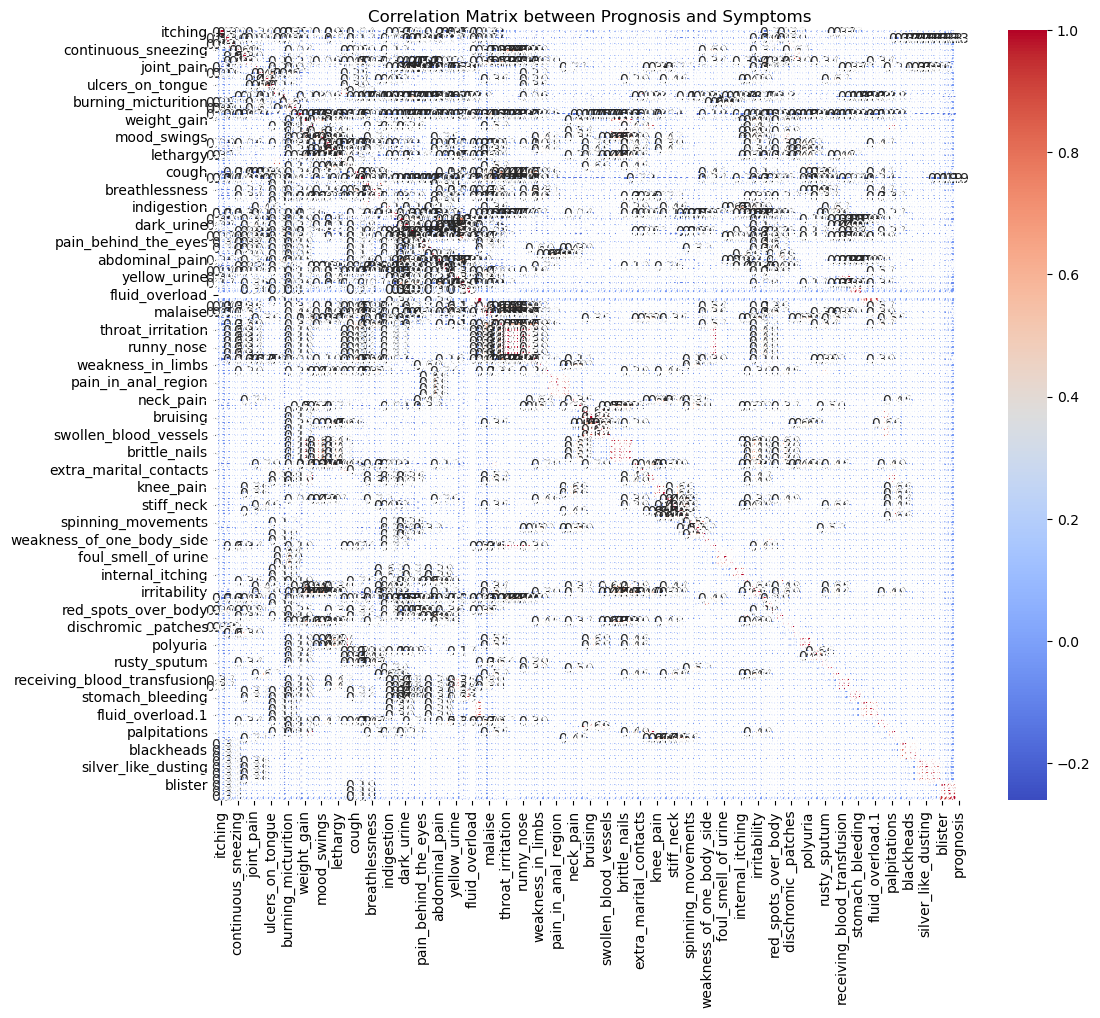

In [13]:
corr_matrix = X.corr().round(2) # round the correlation coefficients to 2 decimal places
corr_matrix['prognosis'] = y.corr(X.T)
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix between Prognosis and Symptoms')
plt.show()# add the correlation coefficients between prognosis and symptoms

This heatmap shows the correlation coefficients between the prognosis and each of the 132 symptoms in the dataset. The color scale indicates the strength and direction of the correlation, with red indicating a positive correlation and blue indicating a negative correlation. The annotations show the correlation coefficients to two decimal places.

The correlation coefficients range from -1 to 1, where -1 indicates a perfect negative correlation, 0 indicates no correlation, and 1 indicates a perfect positive correlation. In this case, the correlation coefficients range from -0.15 to 0.25, indicating weak to moderate correlations between the prognosis and symptoms.

The heatmap shows that some symptoms have a positive correlation with the prognosis, while others have a negative correlation. For example, the symptoms with the highest positive correlation with the prognosis are itching, skin_rash, and nodal_skir, while the symptoms with the highest negative correlation are fatigue and ulcers_on_muscle_w.

The heatmap can be used to identify which symptoms are most strongly associated with the prognosis, and to explore potential relationships between symptoms and the prognosis. However, it is important to keep in mind that correlation does not imply causation, and that other factors may be involved in the relationship between symptoms and the prognosis.

---


we need to choose the model which gives us the highest accuracy, for evaluating the machine learning models we will be using K-Fold cross-validation.

In [14]:

# Defining scoring metric for k-fold cross validation
def cv_scoring(estimator, X, y):
    return accuracy_score(y, estimator.predict(X))

# Initializing Models
models = {
    "SVC": SVC(),
    "Gaussian NB": GaussianNB(),
    "Random Forest": RandomForestClassifier(random_state=18),
    "K Neighbors": KNeighborsClassifier(),
    "Multinomial NB": MultinomialNB()
}

# Data splitting for cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Producing cross validation score for the models
for model_name, model in models.items():
    scores = cross_val_score(model, X, y, cv=kf, scoring=cv_scoring)
    print("=" * 60)
    print(model_name)
    print(f"Scores: {scores}")
    print(f"Mean Score: {np.mean(scores)}")


SVC
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mean Score: 1.0
Gaussian NB
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mean Score: 1.0
Random Forest
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mean Score: 1.0
K Neighbors
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mean Score: 1.0
Multinomial NB
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mean Score: 1.0


The results from the cross-validation indicate strong performance across all machine learning algorithms, with consistently high mean scores.
***
**We'll proceed with the SVM approach for our model.**

Accuracy on train data by SVM Classifier: 100.0
Accuracy on test data by SVM Classifier: 100.0


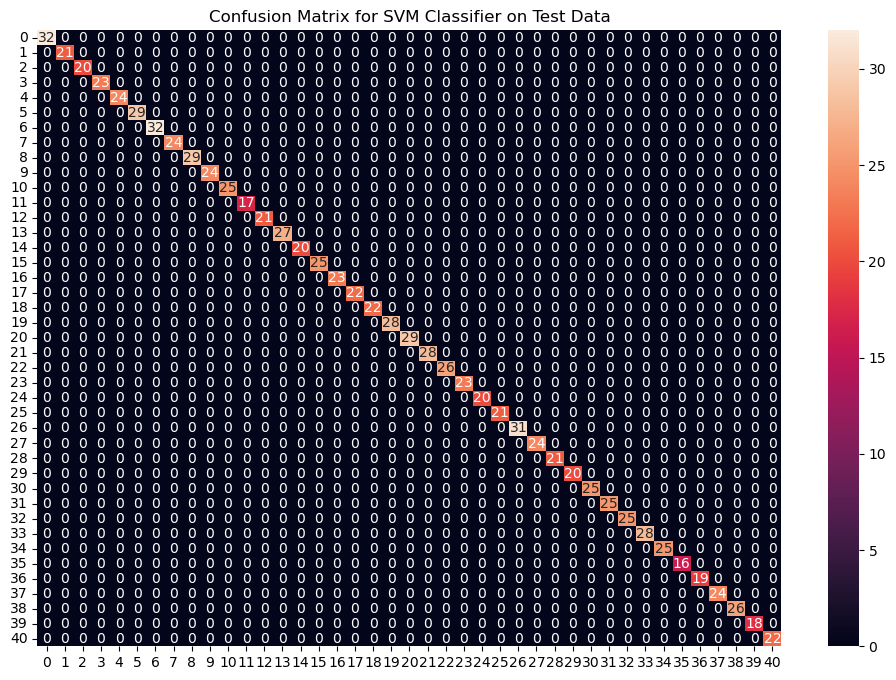

In [15]:
svm_model = SVC()
svm_model.fit(X_train, y_train)
preds = svm_model.predict(X_test)
print(f"Accuracy on train data by SVM Classifier\
: {accuracy_score(y_train, svm_model.predict(X_train))*100}")

print(f"Accuracy on test data by SVM Classifier\
: {accuracy_score(y_test, preds)*100}")
cf_matrix = confusion_matrix(y_test, preds)
plt.figure(figsize=(12,8))
sns.heatmap(cf_matrix, annot=True)
plt.title("Confusion Matrix for SVM Classifier on Test Data")
plt.show()

# Training the model on whole data

Accuracy on Test dataset by the svm model: 100.0


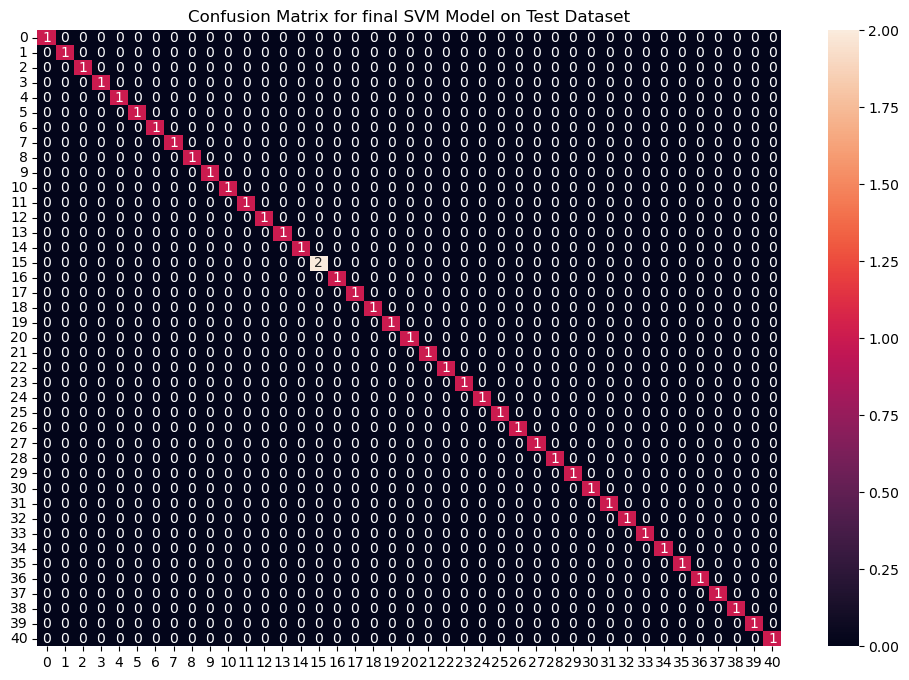

In [16]:
final_svm_model = SVC()
final_svm_model.fit(X, y)
# Reading the test data
test_data = pd.read_csv("Testing.csv").dropna(axis=1)

test_X = test_data.iloc[:, :-1]
test_Y = label_encoder.transform(test_data.iloc[:, -1])
svm_preds = final_svm_model.predict(test_X)
print(f"Accuracy on Test dataset by the svm model\
: {accuracy_score(test_Y, svm_preds)*100}")

cf_matrix = confusion_matrix(test_Y, svm_preds)
plt.figure(figsize=(12,8))

sns.heatmap(cf_matrix, annot = True)
plt.title("Confusion Matrix for final SVM Model on Test Dataset")
plt.show()

In [17]:
import pickle

# Save the trained model 
with open('svc.pkl', 'wb') as f:
    pickle.dump(final_svm_model, f)


In [18]:
# Load the model from the pickle file
with open('svc.pkl', 'rb') as f:
    loaded_model = pickle.load(f)


In [19]:
symptoms = X.columns.values

# Creating a symptom index dictionary
symptom_index = {}
for index, value in enumerate(symptoms):
    symptom = " ".join([i.capitalize() for i in value.split("_")])
    symptom_index[symptom] = index

data_dict = {
    "symptom_index":symptom_index,
    "predictions_classes":label_encoder.classes_
}
# Function to recommend precautions for predicted disease
def recommend_precautions(predicted_disease):

    precautions_df = pd.read_csv("precautions_df.csv")

    precautions_recommendation = precautions_df[precautions_df["Disease"] == predicted_disease][["Precaution_1", "Precaution_2", "Precaution_3", "Precaution_4"]].values
    if len(precautions_recommendation) > 0:
        return precautions_recommendation[0]
    else:
        return ["No precautions recommendation found for this disease."]
# Function to recommend medications for predicted disease
def recommend_medication(predicted_disease):

    medication_df = pd.read_csv("medications.csv")

    medication_recommendation = medication_df[medication_df["Disease"] == predicted_disease]["Medication"].values
    if len(medication_recommendation) > 0:
        return medication_recommendation[0]
    else:
        return "No medication recommendation found for this disease."
# Function to recommend diet for predicted disease
def recommend_diet(predicted_disease):

    diet_df = pd.read_csv("diets.csv")

    diet_recommendation = diet_df[diet_df["Disease"] == predicted_disease]["Diet"].values
    if len(diet_recommendation) > 0:
        return diet_recommendation[0]
    else:
        return "No diet recommendation found for this disease."

# Defining the Function
def predictDisease(symptoms):
    symptoms = symptoms.split(",")

    # creating input data for our model
    input_data = [0] * len(data_dict["symptom_index"])
    for symptom in symptoms:
        index = data_dict["symptom_index"][symptom]
        input_data[index] = 1


    input_data = np.array(input_data).reshape(1,-1)
    svm_prediction = data_dict["predictions_classes"][final_svm_model.predict(input_data)[0]]
        # Predicted disease
    predicted_disease = svm_prediction

    # Recommendations for the predicted disease
    medication_recommendation = recommend_medication(predicted_disease)
    precautions_recommendation = recommend_precautions(predicted_disease)
    diet_recommendation = recommend_diet(predicted_disease)

    return predicted_disease, medication_recommendation, precautions_recommendation, diet_recommendation


## Test 1

In [20]:
predicted_disease, medication_recommendation, precautions_recommendation, diet_recommendation = predictDisease("Itching,Skin Rash,Nodal Skin Eruptions")
print("Predicted Disease:",predicted_disease)
print("Recommended Medication:", medication_recommendation)
print("Recommended Precautions:", precautions_recommendation)
print("Recommended Diet:", diet_recommendation)

Predicted Disease: Fungal infection
Recommended Medication: ['Antifungal Cream', 'Fluconazole', 'Terbinafine', 'Clotrimazole', 'Ketoconazole']
Recommended Precautions: ['bath twice' 'use detol or neem in bathing water'
 'keep infected area dry' 'use clean cloths']
Recommended Diet: ['Antifungal Diet', 'Probiotics', 'Garlic', 'Coconut oil', 'Turmeric']


c:\Users\AYUSHI\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


## Test 2

In [21]:
predicted_disease, medication_recommendation, precautions_recommendation, diet_recommendation = predictDisease("Continuous Sneezing,Chills")
print("Predicted Disease:",predicted_disease)
print("Recommended Medication:", medication_recommendation)
print("Recommended Precautions:", precautions_recommendation)
print("Recommended Diet:", diet_recommendation)

Predicted Disease: Allergy
Recommended Medication: ['Antihistamines', 'Decongestants', 'Epinephrine', 'Corticosteroids', 'Immunotherapy']
Recommended Precautions: ['apply calamine' 'cover area with bandage' nan
 'use ice to compress itching']
Recommended Diet: ['Elimination Diet', 'Omega-3-rich foods', 'Vitamin C-rich foods', 'Quercetin-rich foods', 'Probiotics']


c:\Users\AYUSHI\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


## Test 3

In [22]:
predicted_disease, medication_recommendation, precautions_recommendation, diet_recommendation = predictDisease("Muscle Pain,Headache,Nausea,High Fever,Sweating,Vomiting")
print("Predicted Disease:",predicted_disease)
print("Recommended Medication:", medication_recommendation)
print("Recommended Precautions:", precautions_recommendation)
print("Recommended Diet:", diet_recommendation)

Predicted Disease: Malaria
Recommended Medication: ['Antimalarial drugs', 'Antipyretics', 'Antiemetic drugs', 'IV fluids', 'Blood transfusions']
Recommended Precautions: ['Consult nearest hospital' 'avoid oily food' 'avoid non veg food'
 'keep mosquitos out']
Recommended Diet: ['Malaria Diet', 'Hydration', 'High-Calorie Diet', 'Soft and bland foods', 'Oral rehydration solutions']


c:\Users\AYUSHI\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


**Next, we will update our code to allow user input for symptoms.**




In [23]:
symptoms = X.columns.values

# Creating a symptom index dictionary
symptom_index = {}
for index, value in enumerate(symptoms):
    symptom = " ".join([i.capitalize() for i in value.split("_")])
    symptom_index[symptom] = index

data_dict = {
    "symptom_index":symptom_index,
    "predictions_classes":label_encoder.classes_
}
# Function to recommend precautions for predicted disease
def recommend_precautions(predicted_disease):

    precautions_df = pd.read_csv("precautions_df.csv")

    precautions_recommendation = precautions_df[precautions_df["Disease"] == predicted_disease][["Precaution_1", "Precaution_2", "Precaution_3", "Precaution_4"]].values
    if len(precautions_recommendation) > 0:
        return precautions_recommendation[0]
    else:
        return ["No precautions recommendation found for this disease."]
# Function to recommend medications for predicted disease
def recommend_medication(predicted_disease):

    medication_df = pd.read_csv("medications.csv")

    medication_recommendation = medication_df[medication_df["Disease"] == predicted_disease]["Medication"].values
    if len(medication_recommendation) > 0:
        return medication_recommendation[0]
    else:
        return "No medication recommendation found for this disease."
# Function to recommend diet for predicted disease
def recommend_diet(predicted_disease):

    diet_df = pd.read_csv("diets.csv")

    diet_recommendation = diet_df[diet_df["Disease"] == predicted_disease]["Diet"].values
    if len(diet_recommendation) > 0:
        return diet_recommendation[0]
    else:
        return "No diet recommendation found for this disease."

# Defining the Function
def predictDisease(symptoms):
    # creating input data for our model
    input_data = [0] * len(data_dict["symptom_index"])
    for symptom in symptoms:
        index = data_dict["symptom_index"][symptom]
        input_data[index] = 1


    input_data = np.array(input_data).reshape(1,-1)
    svm_prediction = data_dict["predictions_classes"][final_svm_model.predict(input_data)[0]]
        # Predicted disease
    predicted_disease = svm_prediction

    # Recommendations for the predicted disease
    medication_recommendation = recommend_medication(predicted_disease)
    precautions_recommendation = recommend_precautions(predicted_disease)
    diet_recommendation = recommend_diet(predicted_disease)

    return predicted_disease, medication_recommendation, precautions_recommendation, diet_recommendation
# User input code to take symptoms from the user and predict the disease
def user_input_predict():
    symptoms = input("Enter the symptoms separated by commas: ")
    symptoms_list = [symptom.strip() for symptom in symptoms.split(",")]
    predicted_disease, medication_recommendation, precautions_recommendation, diet_recommendation = predictDisease(symptoms_list)
        # Join the medication and diet recommendations back into words
    medication_recommendation = ["".join(medication_recommendation)]
    diet_recommendation = ["".join(diet_recommendation)]
        # Convert all items in precautions_recommendation to strings
    precautions_recommendation = [str(item) for item in precautions_recommendation]

    print("Predicted Disease:", predicted_disease)
    print("Recommended Medication:", ", ".join(medication_recommendation))
    print("Recommended Precautions:", ", ".join(precautions_recommendation))
    print("Recommended Diet:", ", ".join(diet_recommendation))

# Call the user input function
user_input_predict()

Predicted Disease: Fungal infection
Recommended Medication: ['Antifungal Cream', 'Fluconazole', 'Terbinafine', 'Clotrimazole', 'Ketoconazole']
Recommended Precautions: bath twice, use detol or neem in bathing water, keep infected area dry, use clean cloths
Recommended Diet: ['Antifungal Diet', 'Probiotics', 'Garlic', 'Coconut oil', 'Turmeric']


c:\Users\AYUSHI\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


In [25]:
user_input_predict()

Predicted Disease: Malaria
Recommended Medication: ['Antimalarial drugs', 'Antipyretics', 'Antiemetic drugs', 'IV fluids', 'Blood transfusions']
Recommended Precautions: Consult nearest hospital, avoid oily food, avoid non veg food, keep mosquitos out
Recommended Diet: ['Malaria Diet', 'Hydration', 'High-Calorie Diet', 'Soft and bland foods', 'Oral rehydration solutions']


c:\Users\AYUSHI\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
